In [1]:
import os
import math
import warnings
from dataclasses import dataclass

import torch
from torch import Tensor
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine
from botorch.test_functions import SyntheticTestFunction
from botorch.settings import debug

from abc import ABC
from typing import List, Optional, Tuple, Union
from botorch.exceptions.errors import InputDataError
from botorch.test_functions.base import BaseTestProblem, ConstrainedBaseTestProblem
from botorch.test_functions.utils import round_nearest



# Constrained Max Posterior Sampling s a new sampling class, similar to MaxPosteriorSampling,
# which implements the constrained version of Thompson Sampling described in [1].
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize


import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Change to 'cuda' if using GPU
}

print(device)
print(tkwargs)


cuda
{'dtype': torch.float64, 'device': device(type='cuda')}


min f(x) s.t. c1(x)>0 und c2(x)>0.

f(x) = (1.0-x[0])* (1.0-x[0]) + 100.0 *(x[1]-x[0]*x[0])*(x[1]-x[0]*x[0])

c1(x) = x[1] - x[0]*x[0]

c2(x) = (x[0]-1)**3 - x[1] + 0.7



-1.5 < x1< 1.5

-0.5 < x2 < 2.5



maximum 100 Funktionbewertungen insgesamt.


Plot Raster, turbo visualisieren

### Our Function

In [2]:
def f(X, negate):
    result = (1.0 - X[0])**2 + 100.0*((X[1]-X[0]**2)**2)
    return result if not negate else -result


bounds = torch.tensor([
    [-1.5, -0.5],  # Lower bounds for x1 and x2
    [1.5, 2.5]    # Upper bounds for x1 and x2
], dtype=torch.float, device = device)

dim = 2
lb , ub = bounds

batch_size = 10
n_init = 10
max_cholesky_size = float("inf")  # Always use Cholesky

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    
    return f(unnormalize(x.to(device), bounds) , True)

# Constrain Functions

In [3]:
def c1(x):  # Equivalent to enforcing that x[1] - x[0]^2 > 0
    return x[0]**2 - x[1]


def c2(x):  # Equivalent to enforcing that  (x[0] - 1)^3 - x[1] + 0.7 > 0
    return x[1] - 0.7 - (x[0] - 1)**3



#TODO
# We assume c1, c2 have same bounds as the Ackley function above
def eval_c1(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c1(unnormalize(x, bounds))


def eval_c2(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c2(unnormalize(x, bounds))


# ScBo (Turbo based) (Keep unchanged)

In [4]:
@dataclass
class ScboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    best_constraint_values: Tensor = torch.ones(2, **tkwargs) * torch.inf
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(max([4.0 / self.batch_size, float(self.dim) / self.batch_size]))
        


def get_best_index_for_batch(Y: Tensor, C: Tensor):
    """Return the index for the best point."""
    is_feas = (C <= 0).all(dim=-1)
    if is_feas.any():  # Choose best feasible candidate
        score = Y.clone()
        score[~is_feas] = -float("inf")
        return score.argmax()
    return C.clamp(min=0).sum(dim=-1).argmin()

def update_tr_length(state: ScboState):
    # Update the length of the trust region according to
    # success and failure counters
    # (Just as in original TuRBO paper)
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    if state.length < state.length_min:  # Restart when trust region becomes too small
        state.restart_triggered = True

    return state

def update_state(state, Y_next, C_next):
    """Method used to update the TuRBO state after each step of optimization.

    Success and failure counters are updated according to the objective values
    (Y_next) and constraint values (C_next) of the batch of candidate points
    evaluated on the optimization step.

    As in the original TuRBO paper, a success is counted whenver any one of the
    new candidate points improves upon the incumbent best point. The key difference
    for SCBO is that we only compare points by their objective values when both points
    are valid (meet all constraints). If exactly one of the two points being compared
    violates a constraint, the other valid point is automatically considered to be better.
    If both points violate some constraints, we compare them inated by their constraint values.
    The better point in this case is the one with minimum total constraint violation
    (the minimum sum of constraint values)"""

    # Pick the best point from the batch
    best_ind = get_best_index_for_batch(Y=Y_next, C=C_next)
    y_next, c_next = Y_next[best_ind], C_next[best_ind]

    if (c_next <= 0).all():
        # At least one new candidate is feasible
        improvement_threshold = state.best_value + 1e-3 * math.fabs(state.best_value)
        if y_next > improvement_threshold or (state.best_constraint_values > 0).any():
            state.success_counter += 1
            state.failure_counter = 0
            state.best_value = y_next.item()
            state.best_constraint_values = c_next
        else:
            state.success_counter = 0
            state.failure_counter += 1
    else:
        # No new candidate is feasible
        total_violation_next = c_next.clamp(min=0).sum(dim=-1)
        total_violation_center = state.best_constraint_values.clamp(min=0).sum(dim=-1)
        if total_violation_next < total_violation_center:
            state.success_counter += 1
            state.failure_counter = 0
            state.best_value = y_next.item()
            state.best_constraint_values = c_next
        else:
            state.success_counter = 0
            state.failure_counter += 1

    # Update the length of the trust region according to the success and failure counters
    state = update_tr_length(state)
    return state

# Generate Batch and Functions

In [5]:
#Überprüfe ob random
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    C,  # Constraint values
    batch_size,
    n_candidates,  # Number of candidates for Thompson sampling
    constraint_model,
    sobol: SobolEngine,
):
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    # Create the TR bounds
    best_ind = get_best_index_for_batch(Y=Y, C=C)
    x_center = X[best_ind, :].clone()
    tr_lb = torch.clamp(x_center - state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + state.length / 2.0, 0.0, 1.0)

    # Thompson Sampling w/ Constraints (SCBO)
    dim = X.shape[-1]
    pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / dim, 1.0)
    mask = torch.rand(n_candidates, dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = x_center.expand(n_candidates, dim).clone()
    X_cand[mask] = pert[mask]

    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=model, constraint_model=constraint_model, replacement=False
    )
    with torch.no_grad():
        X_next = constrained_thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

In [6]:
gpytorch.settings.show_progress_bars = True


def get_fitted_model(X, Y):
    assert not torch.isnan(X).any(), "Training data contains NaN values"
    assert not torch.isnan(Y).any(), "Training labels contain NaN values"
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=1.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(
        X,
        Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        fit_gpytorch_mll(mll)

    return model

In [7]:
def search_optimum_constrained(
    n_init,
    generate_points_fun,
    eval_objective_fun,
    eval_constrain_functions,
    state,
    generate_batch_fun,
    fitted_model_fun
):
    # Generate initial data
    dim = state.dim
    batch_size = state.batch_size
    N_CANDIDATES = 30 if not SMOKE_TEST else 4
    sobol = SobolEngine(dim, scramble=True, seed=1)
    
    train_X = generate_points_fun(dim, n_init)
    train_Y = torch.tensor([eval_objective_fun(x) for x in train_X], **tkwargs).unsqueeze(-1)

    '''for eval_constrain_fun in eval_constrain_functions:
        if(i == 0):
            C = torch.tensor([eval_constrain_fun(x) for x in train_X], **tkwargs).unsqueeze(-1)
            i += 1
            continue
        C_i = torch.tensor([eval_constrain_fun(x) for x in train_X], **tkwargs).unsqueeze(-1)
        C = torch.cat([C, C_i], dim=-1)'''
    
    C = [torch.tensor([eval_constrain_fun(x) for x in train_X], **tkwargs).unsqueeze(-1) for eval_constrain_fun in eval_constrain_functions]

    debugging = False
    while not state.restart_triggered and not debugging:  # Run until TuRBO converges
        # Fit GP models for objective and constraints
        model = fitted_model_fun(train_X, train_Y)
        C_model = [get_fitted_model(train_X, C_i) for C_i in C]
        
        # Generate a batch of candidates
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            X_next = generate_batch_fun(
                state=state,
                model=model,
                X=train_X,
                Y=train_Y,
                C=torch.cat(C, dim=-1),
                batch_size=batch_size,
                n_candidates=N_CANDIDATES,
                constraint_model=ModelListGP(*C_model),
                sobol=sobol,
        )
        # Evaluate both the objective and constraints for the selected candidaates
        Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
        C_next = [torch.tensor([eval_constrain_fun(x) for x in X_next], **tkwargs).unsqueeze(-1) for eval_constrain_fun in eval_constrain_functions]

        # Update TuRBO state
        state = update_state(state=state, Y_next=Y_next, C_next=torch.cat(C_next, dim=-1))
        # Append data. Note that we append all data, even points that violate
        # the constraints. This is so our constraint models can learn more
        # about the constraint functions and gain confidence in where violations occur.
        train_X = torch.cat((train_X, X_next), dim=0)
        train_Y = torch.cat((train_Y, Y_next), dim=0)
        for i in range(len(C_next)):
            C[i] = torch.cat((C[i] , C_next[i]) , dim=0)

        # Print current status. Note that state.best_value is always the best
        # objective value found so far which meets the constraints, or in the case
        # that no points have been found yet which meet the constraints, it is the
        # objective value of the point with the minimum constraint violation.
        if (state.best_constraint_values <= 0).all():
            print(f"{len(train_X)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")
        else:
            violation = state.best_constraint_values.clamp(min=0).sum()
            print(
                f"{len(train_X)}) No feasible point yet! Smallest total violation: "
                f"{violation:.2e}, TR length: {state.length:.2e}"
            )        
    print("finished")
    return train_X, train_Y, torch.cat(C, dim=-1)
#testing initial:
state = ScboState(dim, batch_size=5)
X, Y, C = search_optimum_constrained(10, get_initial_points, eval_objective, [eval_c1, eval_c2], state, generate_batch, get_fitted_model)

15) No feasible point yet! Smallest total violation: 2.30e-03, TR length: 8.00e-01
20) Best value: -7.30e-01, TR length: 8.00e-01
25) Best value: -7.30e-01, TR length: 4.00e-01
30) Best value: -7.30e-01, TR length: 2.00e-01
35) Best value: -5.36e-01, TR length: 2.00e-01
40) Best value: -2.13e-01, TR length: 2.00e-01
45) Best value: -2.13e-01, TR length: 1.00e-01
50) Best value: -5.09e-02, TR length: 1.00e-01
55) Best value: -5.09e-02, TR length: 5.00e-02
60) Best value: -3.18e-02, TR length: 5.00e-02
65) Best value: -3.18e-02, TR length: 2.50e-02
70) Best value: -3.18e-02, TR length: 1.25e-02
75) Best value: -3.18e-02, TR length: 6.25e-03
finished


# Start Turbo

75


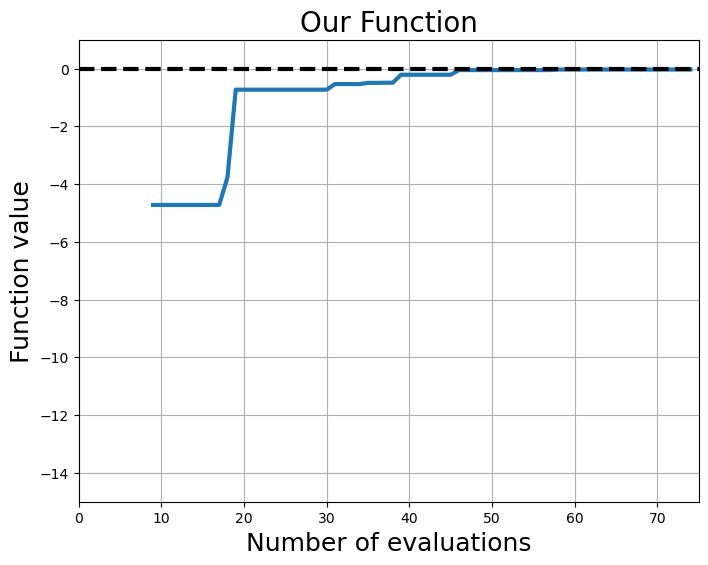

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_fun(X, Y, C):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Clone Y to avoid modifying the original tensor
    score = Y.clone()
    
    # Set infeasible points to -inf
    infeasible_mask = ~(C <= 0).all(dim=-1)
    score[infeasible_mask] = float("-inf")
    
    # Compute the maximum accumulated value
    fx = np.maximum.accumulate(score.cpu().numpy())
    
    # Plot the function values
    plt.plot(fx, marker="", lw=3)

    # Plot a reference line at y=0
    plt.plot([0, len(Y)], [0, 0], "k--", lw=3)
    
    # Set plot labels and title
    plt.ylabel("Function value", fontsize=18)
    plt.xlabel("Number of evaluations", fontsize=18)
    plt.title("Our Function", fontsize=20)
    
    # Set plot limits
    plt.xlim([0, len(Y)])
    plt.ylim([-15, 1])

    # Enable grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

print(len(X))

plot_fun(X,Y,C)

# Draw Result

In [9]:
'''
def michalewicz_10d(x, m=10):
    """
    Evaluate the 10-dimensional Michalewicz function.
    
    Parameters:
    x : array_like
        Input array of 10 dimensions.
    m : int, optional
        Parameter m of the Michalewicz function, default is 10.
    
    Returns:
    float
        Function value.
    """
    if len(x) != 10:
        raise ValueError("Input vector must have 10 dimensions.")
    
    term = 0
    for i in range(10):
        term += np.sin(x[i]) * (np.sin(((i + 1) * x[i]**2) / np.pi))**(2 * m)
    
    return -term



bounds = torch.tensor([
    [0, 0, 0 , 0 , 0 , 0, 0 , 0 ,0 , 0],  # Lower bounds for x1 and x2
    [np.pi , np.pi, np.pi, np.pi, np.pi, np.pi, np.pi, np.pi ,np.pi ,np.pi]    # Upper bounds for x1 and x2
], dtype=torch.double, device = device)

dim = 10
lb , ub = bounds

batch_size = 10
n_init = 10
max_cholesky_size = float("inf")  # Always use Cholesky

def eval_objective_michale(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return michalewicz_10d(unnormalize(x.to(device), bounds) , True)


Das Problem ist dann:

min f(x)

0 < x_i < np.pi, i = 1,...,10

Insgesamt 300 Samples.

x = get_initial_points(10, 1)
print(x)
print(len(x[0]))
eval_objective_michale(x)

#X, Y, C = search_optimum_constrained(10, get_initial_points, eval_objective_michale, [] , state, generate_batch, get_fitted_model)
'''

'\ndef michalewicz_10d(x, m=10):\n    """\n    Evaluate the 10-dimensional Michalewicz function.\n    \n    Parameters:\n    x : array_like\n        Input array of 10 dimensions.\n    m : int, optional\n        Parameter m of the Michalewicz function, default is 10.\n    \n    Returns:\n    float\n        Function value.\n    """\n    if len(x) != 10:\n        raise ValueError("Input vector must have 10 dimensions.")\n    \n    term = 0\n    for i in range(10):\n        term += np.sin(x[i]) * (np.sin(((i + 1) * x[i]**2) / np.pi))**(2 * m)\n    \n    return -term\n\n\n\nbounds = torch.tensor([\n    [0, 0, 0 , 0 , 0 , 0, 0 , 0 ,0 , 0],  # Lower bounds for x1 and x2\n    [np.pi , np.pi, np.pi, np.pi, np.pi, np.pi, np.pi, np.pi ,np.pi ,np.pi]    # Upper bounds for x1 and x2\n], dtype=torch.double, device = device)\n\ndim = 10\nlb , ub = bounds\n\nbatch_size = 10\nn_init = 10\nmax_cholesky_size = float("inf")  # Always use Cholesky\n\ndef eval_objective_michale(x):\n    """This is a helper 

58
tensor([-0.0318], device='cuda:0', dtype=torch.float64)


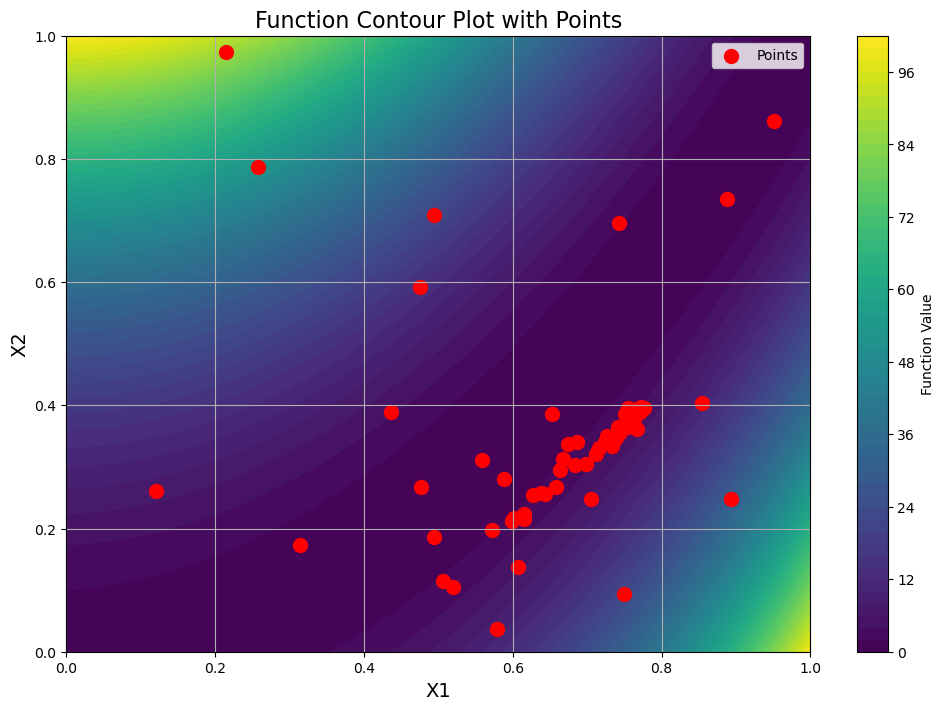

In [12]:
def plot_function_with_points(X, start_idx, end_idx, negate=False, bestIndex = -1):
    """
    Plot the function and highlight points within a given range.
    
    Parameters:
    - X: Tensor containing points (Nx2) where each row is a point [X1, X2].
    - start_idx: Starting index of the points to plot.
    - end_idx: Ending index of the points to plot.
    - negate: Boolean indicating whether to negate the function value.
    """
    # Ensure X is on CPU
    X_cpu = X.cpu() if X.is_cuda else X
    
    # Generate a grid of points
    x = np.linspace(0, 1, 100)  # X1 values
    y = np.linspace(0, 1, 100)  # X2 values
    X1, Y1 = np.meshgrid(x, y)  # Create a grid
    points = torch.tensor(np.vstack([X1.ravel(), Y1.ravel()]), dtype=torch.float32)

    # Evaluate the function
    Z = f(points, negate).detach().numpy().reshape(X1.shape)
    
    # Ensure indices are within bounds
    start_idx = max(0, start_idx)
    end_idx = min(len(X_cpu), end_idx)
    
    # Plot the function
    fig, ax = plt.subplots(figsize=(12, 8))  # Make the plot bigger

    # Contour plot of the function values
    contour = ax.contourf(X1, Y1, Z, levels=50, cmap='viridis')

    # Plot the points within the given range
    if end_idx > start_idx:
        ax.scatter(X_cpu[start_idx:end_idx, 0].numpy(), X_cpu[start_idx:end_idx, 1].numpy(), color='red', marker='o', s=100, label='Points')
    else:
        print("Invalid range: end_idx must be greater than start_idx.")
        
    i

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Function Value')

    # Set labels and title
    ax.set_xlabel('X1', fontsize=14)
    ax.set_ylabel('X2', fontsize=14)
    ax.set_title('Function Contour Plot with Points', fontsize=16)

    # Add grid and legend
    ax.grid(True)
    ax.legend()

    # Show the plot
    plt.show()

best = -8000
index = -1
for i in range(len(Y)):
    if Y[i] > best:
        best = Y[i]
        index = i

print(index)
print(best)
# Example usage:
# Assuming X is already defined and may be on CUDA
plot_function_with_points(X, 0, 100, index)

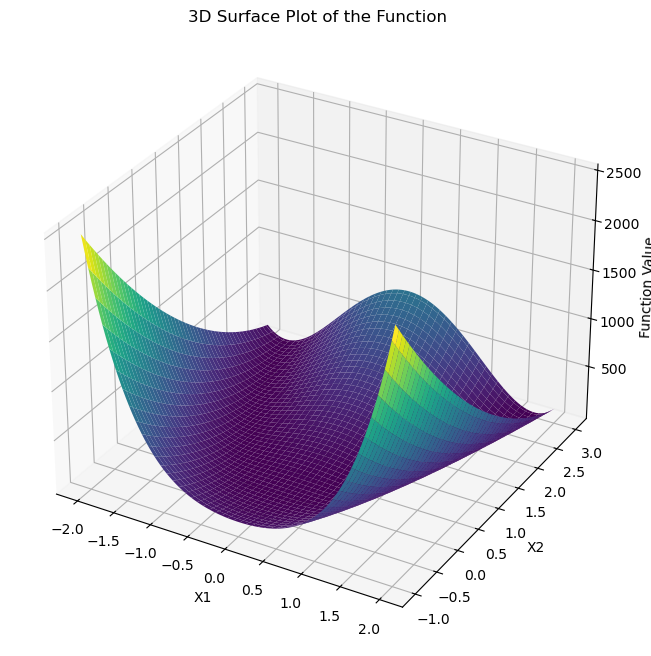

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(X, negate):
    result = (1.0 - X[0])**2 + 100.0*((X[1] - X[0]**2)**2)
    return result if not negate else -result

# Generate a grid of points
x = np.linspace(-2, 2, 100)  # X1 values
y = np.linspace(-1, 3, 100)  # X2 values
X1, Y1 = np.meshgrid(x, y)  # Create a grid
points = torch.tensor(np.vstack([X1.ravel(), Y1.ravel()]), dtype=torch.float32)

# Evaluate the function
negate = False  # Change to True if you want to negate the function
Z = f(points, negate).detach().numpy().reshape(X1.shape)

# Plot the function
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, Z, cmap='viridis')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Function Value')
ax.set_title('3D Surface Plot of the Function')
plt.show()


In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from ipywidgets import widgets, interact

def plot_frame(X, Y, frame):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot of all points up to the current frame
    ax.scatter(X[:frame+1, 0].numpy(), X[:frame+1, 1].numpy(), c='blue')
    
    # Check if we need to highlight the current point
    if frame > 0 and Y[frame] < Y[frame - 1]:
        ax.scatter(X[frame, 0].item(), X[frame, 1].item(), c='red', marker='s', s=100)
    
    # Plot a line at y=0 for reference
    ax.plot([0, len(Y)], [0, 0], "k--", lw=3)
    
    # Set plot limits
    ax.set_xlim([X[:, 0].min().item() - 1, X[:, 0].max().item() + 1])
    ax.set_ylim([X[:, 1].min().item() - 1, X[:, 1].max().item() + 1])
    
    # Set labels and title
    ax.set_ylabel("Y", fontsize=18)
    ax.set_xlabel("X", fontsize=18)
    ax.set_title("ScBO Animation with Trust Region", fontsize=20)
    
    # Enable grid
    ax.grid(True)
    
    plt.show()

def interactive_plot(X, Y):
    # Create an interactive widget for frame control
    interact(lambda frame: plot_frame(X, Y, frame), frame=widgets.IntSlider(min=0, max=len(X)-1, step=1, value=0))

# Example usage:
# Assuming X is a tensor of shape (N, 2) and Y is a tensor of shape (N,)
X = torch.rand(100, 2) * 10  # Example data points
Y = torch.sin(X[:, 0]) - torch.cos(X[:, 1])  # Example function evaluations
interactive_plot(X, Y)


interactive(children=(IntSlider(value=0, description='frame', max=99), Output()), _dom_classes=('widget-intera…